In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/IwM/blood-vessels-detection/
!ls

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/IwM/blood-vessels-detection
data  preprocessing.ipynb  unet.ipynb


In [2]:
%run preprocessing.ipynb

Output hidden; open in https://colab.research.google.com to view.

In [3]:
import tensorflow as tf
import os
from errno import EEXIST
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2

In [4]:

np.random.seed = 42

IMG_WIDTH = 1024
IMG_HEIGHT = 1024
IMG_CHANNELS = 3

TRAIN_PATH = 'data/train/'
IMAGES_PATH = 'images/'
LABELS_PATH = 'labels/'

train_img = sorted( [ f"{TRAIN_PATH + IMAGES_PATH}{file}" for file in os.listdir(TRAIN_PATH + IMAGES_PATH)  ] )
train_labels = sorted( [ f"{TRAIN_PATH + LABELS_PATH}{file}" for file in os.listdir(TRAIN_PATH + LABELS_PATH) ] )


X_train = np.zeros((len(train_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_labels), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


for i, img_file in enumerate(train_img):
    img = imread(img_file)[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img 

    label = imread(train_labels[i])[:, :, np.newaxis]
    label = resize(label, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_train[i] = label

In [5]:
def get_unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    print("Model Compiled")
    return model

In [6]:
model = get_unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print("_______________________________________________________________________________")

checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

trained_model = model.fit(X_train, Y_train, validation_split=0.1, batch_size=2, epochs=100, callbacks=callbacks)
print("_______________________________________________________________________________")

Model Compiled
_______________________________________________________________________________
Epoch 1/100
10/10 [==============================] - 54s 1s/step - loss: 0.5858 - accuracy: 0.8466 - val_loss: 0.4534 - val_accuracy: 0.9173
Epoch 2/100
10/10 [==============================] - 8s 782ms/step - loss: 0.3931 - accuracy: 0.9146 - val_loss: 0.2881 - val_accuracy: 0.9173
Epoch 3/100
10/10 [==============================] - 8s 775ms/step - loss: 0.2811 - accuracy: 0.9127 - val_loss: 0.2702 - val_accuracy: 0.9173
Epoch 4/100
10/10 [==============================] - 8s 782ms/step - loss: 0.2732 - accuracy: 0.9140 - val_loss: 0.2646 - val_accuracy: 0.9173
Epoch 5/100
10/10 [==============================] - 8s 784ms/step - loss: 0.2641 - accuracy: 0.9164 - val_loss: 0.2597 - val_accuracy: 0.9173
Epoch 6/100
10/10 [==============================] - 8s 788ms/step - loss: 0.2624 - accuracy: 0.9148 - val_loss: 0.2562 - val_accuracy: 0.9173
Epoch 7/100
10/10 [==============================

In [7]:
TEST_PATH = 'data/test/'

test_img = sorted( [ f"{TEST_PATH + IMAGES_PATH}{file}" for file in os.listdir(TEST_PATH + IMAGES_PATH)  ] )
test_labels = sorted( [ f"{TEST_PATH + LABELS_PATH}{file}" for file in os.listdir(TEST_PATH + LABELS_PATH) ] )

X_test = np.zeros((len(test_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_labels), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

for i, img_file in enumerate(test_img):
    img = imread(img_file)[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[i] = img  

    label = imread(test_labels[i])[:, :, np.newaxis]
    label = resize(label, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_test[i] = label


predictions_test = model.predict(X_test, verbose=1)
predictions_test_thresh = (predictions_test > 0.15).astype(np.uint8)


title = ["Zdjęcie", "Moja etykieta", "Etykieta"] 
for i in range(len(X_test)):
    pred = np.reshape(predictions_test_thresh[i], (predictions_test_thresh[i].shape[0],predictions_test_thresh[i].shape[1]))
    label = np.reshape(Y_test[i], (Y_test[i].shape[0],Y_test[i].shape[1]))
    cm_data(f"Image_1{i}L", Y_test[i][:,:,0], predictions_test_thresh[i])
    show_images(f"Image_1{i}L",title,X_test[i][:,:,:], pred, label)


Output hidden; open in https://colab.research.google.com to view.

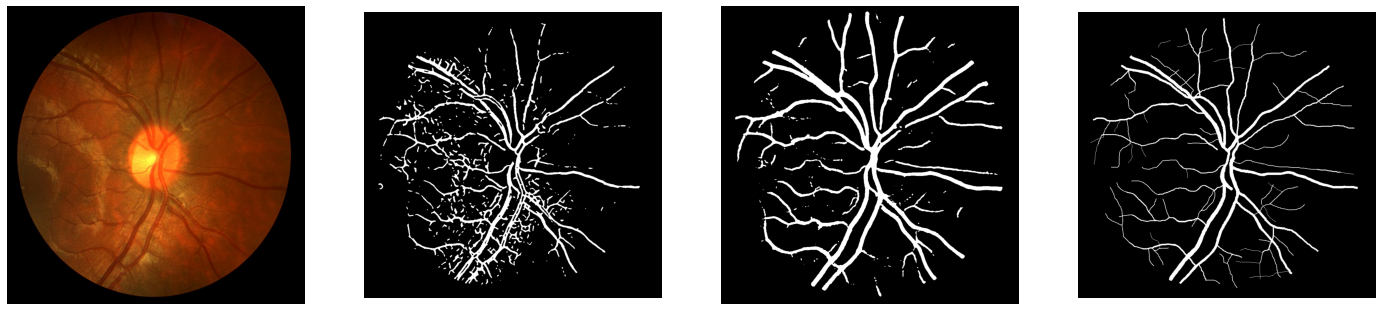

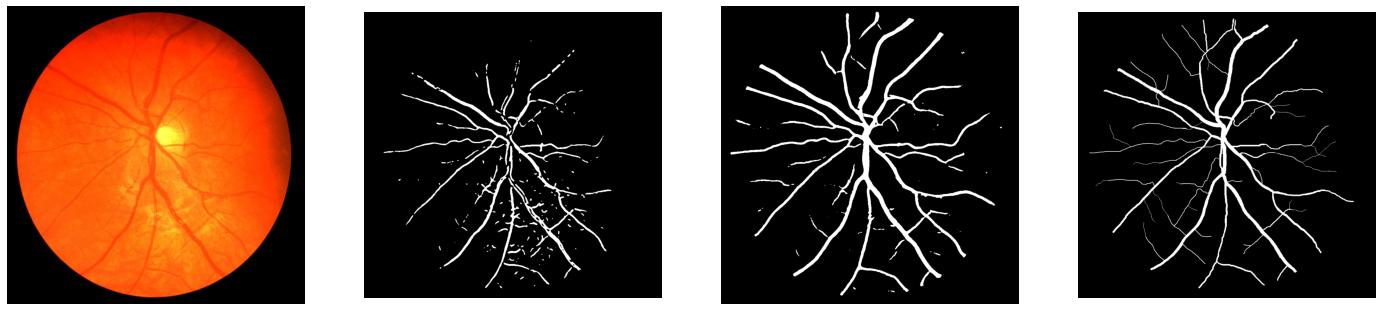

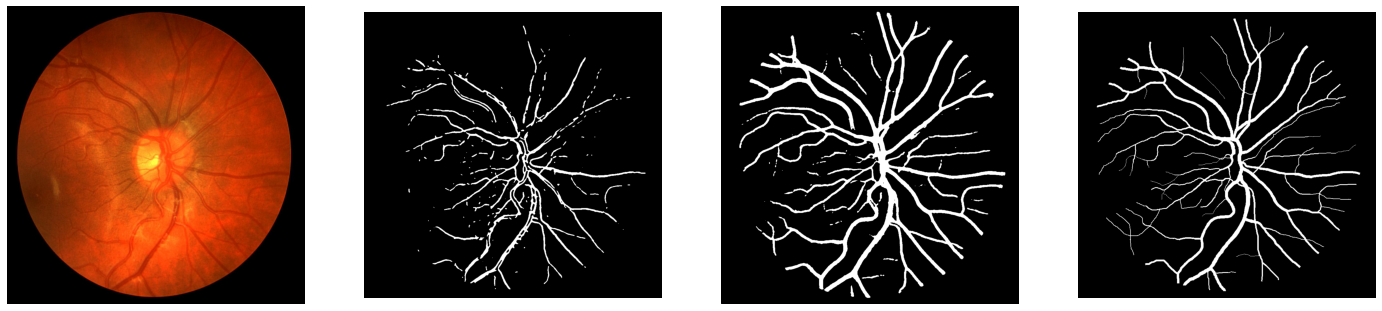

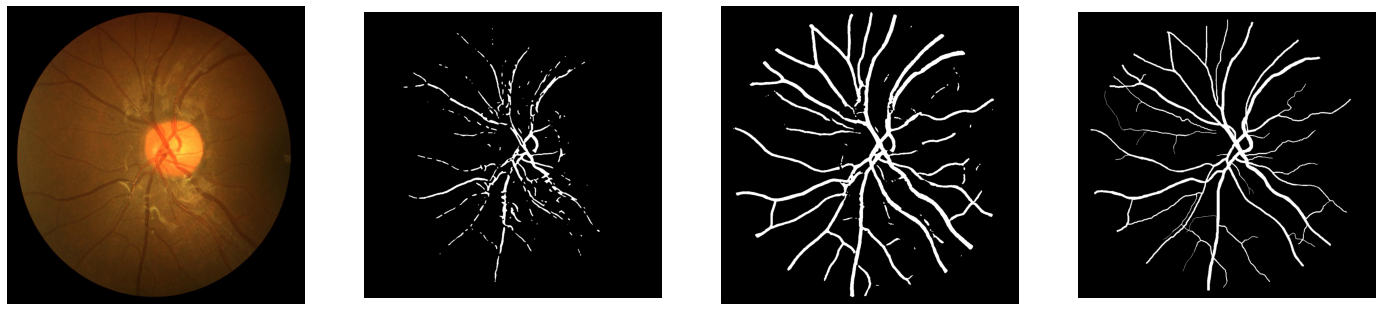

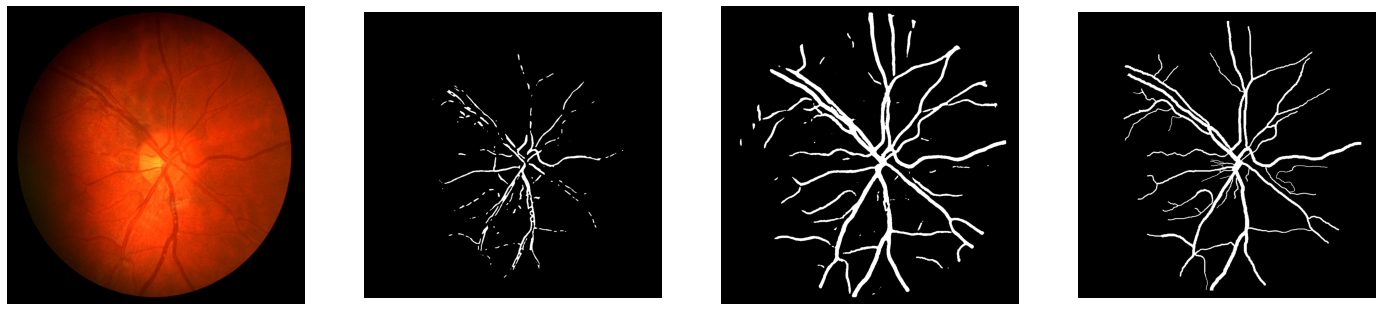

In [8]:
title = ["Zdjęcie", "Moja etykieta", "Moja etykieta - unet", "Etykieta"] 
for i in range(len(X_test)):
    pred = np.reshape(predictions_test_thresh[i], (predictions_test_thresh[i].shape[0],predictions_test_thresh[i].shape[1]))
    show_images('',['','','',''],X_test[i][:,:,:],predicted_labels[i],pred,true_labels[i])
